In [1]:
import gc
import time
import keras as k
import numpy as np
import pandas as pd
import sklearn as sk
import datetime as dt
import keras.backend as K
import matplotlib.pyplot as plt

from keras import regularizers
from keras.models import Model
from keras.layers import Input, Dense, Activation
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.metrics import mean_squared_error, \
                confusion_matrix, classification_report

# custom Fuzzy Layers
from sofenn import SOFNN
from sofenn.layers import FuzzyLayer, NormalizedLayer, WeightedLayer

pd.set_option('display.max_columns', None)

Using TensorFlow backend.


# Inspecting Data

In [2]:
df = pd.read_csv('../data/FinalDataset.csv',index_col='date')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1763 entries, 12/27/13 to 10/24/18
Columns: 132 entries, com_count to bitcoin_market_cap
dtypes: float64(64), int64(68)
memory usage: 1.8+ MB


In [3]:
df.head()

,com_count,sub_count,com_body_pos_count,com_body_very_pos_count,com_body_neg_count,com_body_very_neg_count,sub_body_pos_count,sub_body_very_pos_count,sub_body_neg_count,sub_body_very_neg_count,sub_title_pos_count,sub_title_very_pos_count,sub_title_neg_count,sub_title_very_neg_count,sub_title_non_zero_pr,sub_title_top_50_pr,sub_title_top_75_pr,sub_title_pr_4_bins,sub_title_pr_normalized,sub_title_pr_norm_plus_base,sub_title_pos_non_zero_pr,sub_title_pos_top_50_pr,sub_title_pos_top_75_pr,sub_title_pos_pr_4_bins,sub_title_pos_pr_normalized,sub_title_pos_pr_norm_plus_base,sub_title_very_pos_non_zero_pr,sub_title_very_pos_top_50_pr,sub_title_very_pos_top_75_pr,sub_title_very_pos_pr_4_bins,sub_title_very_pos_pr_normalized,sub_title_very_pos_pr_norm_plus_base,sub_title_neg_non_zero_pr,sub_title_neg_top_50_pr,sub_title_neg_top_75_pr,sub_title_neg_pr_4_bins,sub_title_neg_pr_normalized,sub_title_neg_pr_norm_plus_base,sub_title_very_neg_non_zero_pr,sub_title_very_neg_top_50_pr,sub_title_very_neg_top_75_pr,sub_title_very_neg_pr_4_bins,sub_title_very_neg_pr_normalized,sub_title_very_neg_pr_norm_plus_base,sub_title_very_pos_minus_very_neg_non_zero_pr,sub_title_pos_minus_neg_non_zero_pr,sub_title_pos_non_zero_pr_percent,sub_title_very_pos_non_zero_pr_percent,sub_title_neg_non_zero_pr_percent,sub_title_very_neg_non_zero_pr_percent,sub_body_non_zero_pr,sub_body_top_50_pr,sub_body_top_75_pr,sub_body_pr_4_bins,sub_body_pr_normalized,sub_body_pr_norm_plus_base,sub_body_pos_non_zero_pr,sub_body_pos_top_50_pr,sub_body_pos_top_75_pr,sub_body_pos_pr_4_bins,sub_body_pos_pr_normalized,sub_body_pos_pr_norm_plus_base,sub_body_very_pos_non_zero_pr,sub_body_very_pos_top_50_pr,sub_body_very_pos_top_75_pr,sub_body_very_pos_pr_4_bins,sub_body_very_pos_pr_normalized,sub_body_very_pos_pr_norm_plus_base,sub_body_neg_non_zero_pr,sub_body_neg_top_50_pr,sub_body_neg_top_75_pr,sub_body_neg_pr_4_bins,sub_body_neg_pr_normalized,sub_body_neg_pr_norm_plus_base,sub_body_very_neg_non_zero_pr,sub_body_very_neg_top_50_pr,sub_body_very_neg_top_75_pr,sub_body_very_neg_pr_4_bins,sub_body_very_neg_pr_normalized,sub_body_very_neg_pr_norm_plus_base,sub_body_very_pos_minus_very_neg_non_zero_pr,sub_body_pos_minus_neg_non_zero_pr,sub_body_pos_non_zero_pr_percent,sub_body_very_pos_non_zero_pr_percent,sub_body_neg_non_zero_pr_percent,sub_body_very_neg_non_zero_pr_percent,com_body_non_zero_pr,com_body_top_50_pr,com_body_top_75_pr,com_body_pr_4_bins,com_body_pr_normalized,com_body_pr_norm_plus_base,com_body_pos_non_zero_pr,com_body_pos_top_50_pr,com_body_pos_top_75_pr,com_body_pos_pr_4_bins,com_body_pos_pr_normalized,com_body_pos_pr_norm_plus_base,com_body_very_pos_non_zero_pr,com_body_very_pos_top_50_pr,com_body_very_pos_top_75_pr,com_body_very_pos_pr_4_bins,com_body_very_pos_pr_normalized,com_body_very_pos_pr_norm_plus_base,com_body_neg_non_zero_pr,com_body_neg_top_50_pr,com_body_neg_top_75_pr,com_body_neg_pr_4_bins,com_body_neg_pr_normalized,com_body_neg_pr_norm_plus_base,com_body_very_neg_non_zero_pr,com_body_very_neg_top_50_pr,com_body_very_neg_top_75_pr,com_body_very_neg_pr_4_bins,com_body_very_neg_pr_normalized,com_body_very_neg_pr_norm_plus_base,com_body_very_pos_minus_very_neg_non_zero_pr,com_body_pos_minus_neg_non_zero_pr,com_body_pos_non_zero_pr_percent,com_body_very_pos_non_zero_pr_percent,com_body_neg_non_zero_pr_percent,com_body_very_neg_non_zero_pr_percent,avg_clust_coef,avg_degree,num_edges,num_nodes,bitcoin_open,bitcoin_high,bitcoin_low,bitcoin_close,bitcoin_volume,bitcoin_market_cap
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
12/27/13,6065,477,1516,766,666,253,105,74,14,6,67,10,22,4,151,15,1,96.25,0.584285,4.434285,14,3,0,13.0,0.075103,0.595103,1,0,0,1.75,0.000659,0.070659,9,1,0,4.25,0.025917,0.195917,1,0,0,0.75,0.000924,0.030924,0,5,0.092715,0.006623,0.059603,0.006623,151,15,1,96.25,0.584285,4.434285,36,2,0,21.00,0.107567,0.947567,27,1,0,14.00,0.072764,0.632764,2,0,0,2.75,0.00

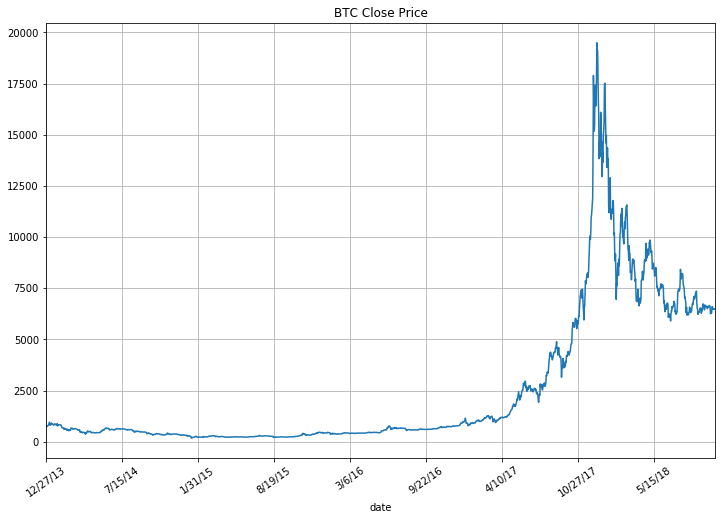

In [4]:
# show closing price time series
df['bitcoin_close'].plot(title='BTC Close Price',grid=True,rot=35, figsize=(12,8))

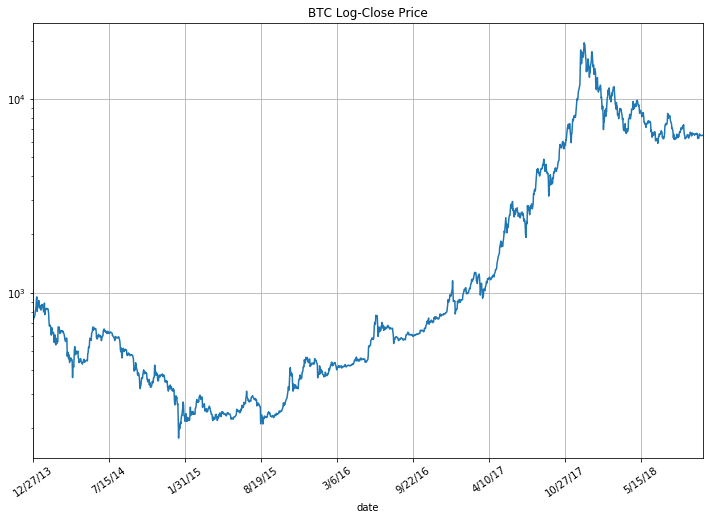

In [5]:
# show log-closing price time series
df['bitcoin_close'].plot(title='BTC Log-Close Price',grid=True,logy=True,rot=35, figsize=(12,8))

In [6]:
# stats on time series length
print("number of days:  {:.1f}".format(df.shape[0]))
print("number of months:  {:.1f}".format(df.shape[0] / 30))
print("number of years:    {:.1f}".format(df.shape[0] / 365))

number of days:  1763.0
number of months:  58.8
number of years:    4.8


# Defining Functions

## Loading and Preparing Data

In [7]:
# function to read in dataset

def get_data():
    return pd.read_csv('../data/FinalDataset.csv',index_col='date')

In [8]:
# function to drop unneeded fields

def keep_only_close(df_in):
    drops = ['bitcoin_open', 'bitcoin_high', 'bitcoin_low',
             'bitcoin_volume', 'bitcoin_market_cap']
    return df_in.drop(drops, axis=1) 

In [9]:
# function to add predicted column for tomorrow's close price

def add_prediction_field(df_in):
    # creating predicted value
    # create column to hold tomorrow's close for each day
    df_in['tomorrow_close'] = df_in['bitcoin_close'].shift(-1)
    # change in price between consecutive closing days
    df_in['day_change'] = df_in['tomorrow_close'] - df_in['bitcoin_close']
    # indicator variable to be used for predicting higher/lower days
    df_in['y'] = np.where(df_in['day_change'] >= 0, 1, 0)
        
    # drop intermediate columns
    return df_in.drop(['tomorrow_close', 'day_change'], axis=1)

In [10]:
# function to retrieve lag values to use for each feature

def get_feature_lag_dict(lag_vers=1):
    # check value of input
    if lag_vers not in [1, 2, 3, 4]:
        raise ValueError('Incorrect Version')
    
    # read in right version of file
    df = pd.read_csv('../lags/optimal_v{}.csv'.format(lag_vers))
    
    # return dictionary of features as keys and lags as values
    return dict(zip(df.feature, df.lags))

In [11]:
# function to add lags for daily features

def add_lags(df_in, lag_vers=1):
    # splitting into X/y for separate processing
    X, y = df_in[df_in.columns[:-1]], df_in[df_in.columns[-1]]
    # save list of columns for lags
    col_list = X.columns
    # create output DF
    df_out = X.copy()
    
    # creating lags
    f_dict = get_feature_lag_dict(lag_vers=lag_vers)
    # create lag columns for each other variable
    for col in col_list:
        if col not in f_dict.keys(): continue
        for lag in range(int(f_dict[col])):
            df_out['{}_(-{})'.format(col,lag+1)] = df_out[col].shift(lag+1)

    # return and drop na
    df_out['y'] = y
    return df_out.dropna()

In [12]:
# function to remove data before certain date

def truncate_date(df_in, first_day='1999-1-1'):
    # set mask of Bool values
    mask = (pd.to_datetime(df_in.index) >= first_day)
    return df_in.loc[mask]

In [13]:
# function to rejoin training data into X/y again

def rejoin_training_data(X_train, X_test, y_train, y_test):
    Xs = [X_train, X_test]
    Ys = [y_train, y_test]
    
    df_out = pd.concat(Xs)
    df_out['y'] = pd.concat(Ys)
    
    return df_out

In [14]:
# function to create train/test X and y
def create_training_data(df_in, lag_vers=1, train_split=0.7, rescale=True, k_feat_perc=None):
    # split into test train
    X, y = df_in[df_in.columns[:-1]], df_in[df_in.columns[-1]]
    
    # determine cutoff of train/test split and split
    cutoff = int(X.shape[0] * train_split)
    X_train, y_train = X[:cutoff], y[:cutoff]
    X_test, y_test = X[cutoff:], y[cutoff:]
    
    # scale values to 0-1
    # must only scale based on training data, to ensure no 
    # foresight with averages
    if rescale:
        scaler = MinMaxScaler(feature_range=(0,1)).fit(X_train.values)
        cols = X.columns
        X_train = pd.DataFrame(scaler.transform(X_train.values), 
                               index=X_train.index, columns=cols)
        X_test = pd.DataFrame(scaler.transform(X_test.values), 
                               index=X_test.index, columns=cols)
    
    # select top K features to use
    if k_feat_perc:
        selector = SelectPercentile(chi2, percentile=k_feat_perc).fit(
                                    X_train.values,y_train.values)
        # index and names of remainig columns after filter
        cols = X_train.columns[selector.get_support(indices = True)]
        X_train = pd.DataFrame(selector.transform(X_train.values), 
                               index=X_train.index, columns=cols)
        X_test = pd.DataFrame(selector.transform(X_test.values), 
                               index=X_test.index, columns=cols)
    
    # recreate into X/y DF and add lags
    df_renew = rejoin_training_data(X_train, X_test, y_train, y_test)
    df_renew = add_lags(df_renew, lag_vers=lag_vers)
    
    # split into test train again
    X, y = df_renew[df_renew.columns[:-1]], df_renew[df_renew.columns[-1]]
    cutoff = int(X.shape[0] * train_split)
    X_train, y_train = X[:cutoff], y[:cutoff]
    X_test, y_test = X[cutoff:], y[cutoff:]

    # display shapes
    print('='*65)
    print('New Training Set')
    print('Training Set Dims: {}'.format(X_train.shape))
    print('Testing Set Dims:  {}'.format(X_test.shape))
    print('='*65)

    return X_train, X_test, y_train, y_test

In [15]:
# function to prep data and return DF for modeling

def prepare_data(lag_vers=1, train_split=0.7, close_o=False, 
                         first_day=None, rescale=True, k_feat_perc=None):
    # read in  dataset and initialize output df
    df_in = get_data()
    
    # drop non-price fields if needed
    if close_o:
        df_in = keep_only_close(df_in)
    
    # add prediction field
    df_in = add_prediction_field(df_in)
    
    # cut off prior to first_day
    if first_day:
        df_in = truncate_date(df_in, first_day)
    
    return create_training_data(df_in, lag_vers=lag_vers, train_split=train_split, 
                                rescale=rescale, k_feat_perc=k_feat_perc)

## Preparing Data for Training

In [16]:
# split dataset
X_train, X_test, y_train, y_test = prepare_data(lag_vers=2, train_split=0.9, close_o=False, 
                                    first_day='2016-7-1', rescale=True, k_feat_perc=25)

New Training Set
Training Set Dims: (749, 149)
Testing Set Dims:  (84, 149)


In [17]:
X_train.shape

(749, 149)

In [18]:
X_test.shape

(84, 149)

In [19]:
y_train.shape

(749,)

In [20]:
y_test.shape

(84,)

In [21]:
# balance of dependent variable values
ones = y_train.sum()
zeros = y_train.shape[0] - ones
print("0's: {}".format(zeros))
print("1's: {}".format(ones))

0's: 316
1's: 433


In [22]:
# balance of dependent variable values
ones = y_test.sum()
zeros = y_test.shape[0] - ones
print("0's: {}".format(zeros))
print("1's: {}".format(ones))

0's: 43
1's: 41


## Build, Train, Test SOFNN Model

In [23]:
sofnn = SOFNN(X_train, X_test, y_train, y_test, neurons=5)

Building SOFNN with 5 neurons
Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Inputs (InputLayer)             (None, 149)          0                                            
__________________________________________________________________________________________________
FuzzyRules (FuzzyLayer)         (None, 5)            1490        Inputs[0][0]                     
__________________________________________________________________________________________________
Normalization (NormalizedLayer) (None, 5)            0           FuzzyRules[0][0]                 
__________________________________________________________________________________________________
Weights (WeightedLayer)         (None, 5)            750         Inputs[0][0]                     
       

In [24]:
sofnn._train_model()
y_pred = sofnn._evaluate_model()

Instructions for updating:
Use tf.cast instead.
Epoch 1/50
749/749 [==============================] - 2s 3ms/step - loss: 0.6917 - acc: 0.5020 - mean_absolute_percentage_error: 214864710.0668
Epoch 2/50
749/749 [==============================] - 0s 143us/step - loss: 0.6862 - acc: 0.5781 - mean_absolute_percentage_error: 224630507.7063
Epoch 3/50
749/749 [==============================] - 0s 168us/step - loss: 0.6830 - acc: 0.5781 - mean_absolute_percentage_error: 231550821.4259
Epoch 4/50
749/749 [==============================] - 0s 147us/step - loss: 0.6809 - acc: 0.5781 - mean_absolute_percentage_error: 235040544.9399
Epoch 5/50
749/749 [==============================] - 0s 148us/step - loss: 0.6794 - acc: 0.5781 - mean_absolute_percentage_error: 236642939.5140
Epoch 6/50
749/749 [==============================] - 0s 155us/step - loss: 0.6780 - acc: 0.5781 - mean_absolute_percentage_error: 237537589.9172
Epoch 7/50
749/749 [==============================] - 0s 145us/step - loss: 0.

## Plot Prediction Results

In [25]:
# plot results

def plot_results():
    # plotting results
    df_plot = pd.DataFrame()

    # create pred/true time series
    df_plot['price'] = df['bitcoin_close'][-84:]
    df_plot['pred'] = y_pred * df_plot['price']
    df_plot['true'] = y_test * df_plot['price']
    df_plot['hits'] = df_plot['price'] * (df_plot['pred'] == df_plot['true'])
    df_plot['miss'] = df_plot['price'] * (df_plot['pred'] != df_plot['true'])

    fig, ax = plt.subplots(figsize=(12,8))
    plt.plot(df_plot['price'], color='b')
    plt.bar(df_plot['price'].index, df_plot['hits'], color='g')
    plt.bar(df_plot['price'].index, df_plot['miss'], color='r')
    for label in ax.xaxis.get_ticklabels()[::400]:
        label.set_visible(False)

    plt.title('BTC Close Price Against Predictions')
    plt.xlabel('Dates')
    plt.ylabel('BTC Price ($)')
    plt.grid(True)
    plt.xticks(df_plot['price'].index[::4], 
               df_plot['price'].index[::4], rotation=70)
    plt.show()

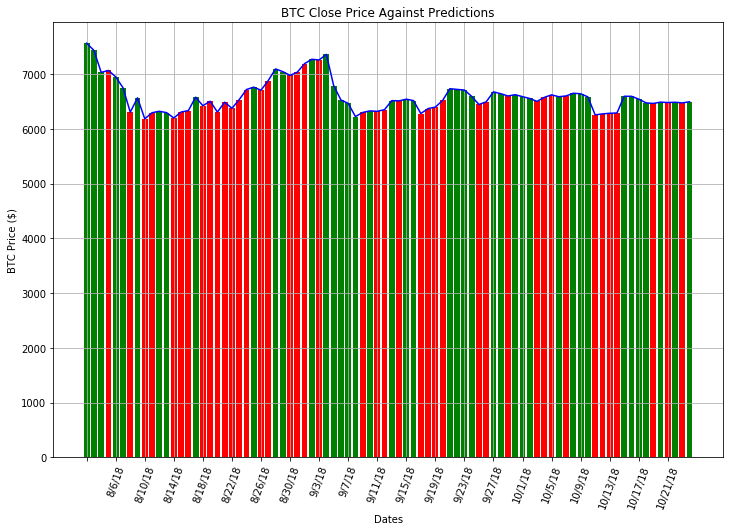

In [26]:
plot_results()

In [27]:
# function to create and train model

def run_model(rules=5, batch_size = 1, epochs=5):
    # get shape of training data
    samples, feats = X_train.shape
    
    # add layers
    inputs = Input(name='Inputs',shape=(feats,))
    fuzz = FuzzyLayer(rules)
    norm = NormalizedLayer(rules)
    weights = WeightedLayer(rules)
    
    # run through layers
    phi = fuzz(inputs)
    phi = norm(phi)
    phi = weights([inputs, phi])
    raw_output = Dense(1, name='RawOutput', activation='linear', use_bias=False)(phi)
    preds = Activation(name='OutputActivation', activation='relu')(raw_output)
    
    # compile model and output summary 
    model = Model(inputs=inputs, outputs=preds)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    
    # fit model and evaluate
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,shuffle=False)
    scores = model.evaluate(X_test, y_test, verbose=1)
    accuracy = scores[1] * 100
    print("\nAccuracy: {:.2f}%".format(accuracy))
    
    # print confusion matrix
    print('\nConfusion Matrix')
    print('='*20)
    y_pred = np.squeeze(np.where(model.predict(X_test) >= 0.5, 1, 0), axis=-1)
    print(pd.DataFrame(confusion_matrix(y_test, y_pred), 
                       index=['true:no', 'true:yes'], columns=['pred:no', 'pred:yes']))
    
    # print classification report
    print('\nClasification Report')
    print('='*20)
    print(classification_report(y_test, y_pred, labels=[0,1]))
    
    return model, y_pred

In [28]:
# test out various nodes
for rule in [5]:
    print('{} Rules'.format(rule))
    model, y_pred = run_model(rules=rule, batch_size=30, epochs=50)

5 Rules
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Inputs (InputLayer)             (None, 149)          0                                            
__________________________________________________________________________________________________
FuzzyRules (FuzzyLayer)         (None, 5)            1490        Inputs[0][0]                     
__________________________________________________________________________________________________
Normalization (NormalizedLayer) (None, 5)            0           FuzzyRules[0][0]                 
__________________________________________________________________________________________________
Weights (WeightedLayer)         (None, 5)            750         Inputs[0][0]                     
                                                                 Normalization[0][0]              
__

C:\Anaconda3\envs\Crypto\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Testing Model Attributes

In [29]:
for layer in model.layers:
    print(layer.name, layer.get_weights())

Inputs []
FuzzyRules [array([[ 1.55480374e-02,  2.55337022e-02,  6.93405373e-03,
         4.47145626e-02,  5.25305122e-02],
       [ 5.74566890e-03,  2.17142534e-02,  1.60033128e-03,
         3.65891084e-02,  5.05646318e-02],
       [-4.72529903e-02,  2.33441666e-02,  4.04232629e-02,
         3.76106575e-02, -4.21550311e-02],
       [ 4.27005291e-02, -2.32452899e-02,  2.47776341e-02,
        -3.01667415e-02,  1.29437493e-02],
       [ 1.58803351e-02,  6.44562067e-03,  2.97954027e-02,
         4.00022864e-02, -3.23678367e-02],
       [-4.66741212e-02, -4.18065265e-02,  2.28569675e-02,
         2.23853234e-02, -3.01500037e-02],
       [ 1.88836139e-02,  4.96588685e-02,  8.17444362e-03,
        -4.31744568e-02, -1.03070715e-03],
       [ 5.41791972e-03, -2.06780322e-02, -2.57220939e-02,
        -4.19162512e-02,  1.02398144e-02],
       [-3.86654623e-02,  3.57004479e-02,  4.75777648e-02,
         1.57535095e-02,  2.11041421e-03],
       [ 1.20650802e-03, -2.95216162e-02, -2.47330181e-02,
 

In [30]:
layer_name = 'Weights'
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer(layer_name).output)
intermediate_output = intermediate_layer_model.predict(X_train)

In [31]:
intermediate_output

array([[ 0.03618305, -0.02715238,  0.02743052,  0.06071761, -0.01568034],
       [ 0.04102971, -0.0223126 ,  0.02417408,  0.05565706, -0.01916973],
       [ 0.03392683, -0.02772975,  0.00884979,  0.05422212, -0.01114258],
       ...,
       [ 0.03009679, -0.0316498 ,  0.01382236,  0.04106771, -0.02834331],
       [ 0.03028862, -0.03147965,  0.01229628,  0.04398552, -0.01521626],
       [ 0.04284317, -0.05625018,  0.02173893,  0.06375998, -0.01794956]],
      dtype=float32)

In [32]:
for layer in model.layers[1:]:
    print(layer.name, '\nInput Shape', layer.input_shape,'\nOutput Shape', layer.output_shape, '\n', 
          '\nTest Shape', sofnn._get_layer_output(layer.name).shape,'\n', sofnn._get_layer_output(layer.name))

FuzzyRules 
Input Shape (None, 149) 
Output Shape (None, 5) 
 
Test Shape (84, 5) 
 [[1.73005006e-07 8.85339458e-12 7.54493135e-11 2.73879639e-08
  8.15323677e-12]
 [1.06940212e-09 1.24294387e-13 4.76831790e-13 2.85528073e-10
  9.97098386e-14]
 [3.24560894e-08 9.54505780e-11 1.65607528e-10 1.54883509e-07
  3.07002046e-09]
 [1.40006421e-06 1.20973436e-08 3.23034861e-08 6.11880478e-06
  1.23739355e-07]
 [3.79520384e-06 6.29559460e-10 7.77255771e-09 9.13449014e-07
  8.03880296e-11]
 [2.90608824e-07 2.97918044e-11 2.54577609e-10 4.01433375e-08
  2.10915313e-11]
 [1.05408295e-08 3.76400056e-13 3.37175904e-12 2.74158446e-10
  2.18129280e-13]
 [2.16334524e-08 1.93322008e-12 1.05390653e-11 1.48949431e-09
  3.29758746e-12]
 [1.74856858e-08 3.03102140e-12 1.42264013e-11 6.88768065e-09
  1.05196043e-11]
 [6.02104421e-07 4.89406293e-10 2.01056349e-09 6.08042114e-07
  7.84751553e-09]
 [1.81665109e-05 1.98925285e-08 1.53859460e-07 1.13565002e-05
  1.57361441e-07]
 [2.21695627e-05 1.34394540e-09 3.16

Weights 
Input Shape [(None, 149), (None, 5)] 
Output Shape (None, 5) 
 
Test Shape (84, 5) 
 [[ 6.59274864e+00  3.82828075e-05 -7.31294334e-04 -7.88026273e-01
  -2.47296157e-05]
 [ 6.29779911e+00  9.64379869e-05 -6.96753792e-04 -1.31402504e+00
  -5.45777038e-05]
 [ 1.21678615e+00  5.24156028e-04 -1.57889700e-03 -4.20320415e+00
  -9.87090264e-03]
 [ 1.23368287e+00  1.42463855e-03 -8.40999000e-03 -3.73608112e+00
  -1.08037507e-02]
 [ 6.08131790e+00  1.04171944e-04 -3.75565235e-03 -1.04108262e+00
  -1.09875009e-05]
 [ 7.29462242e+00  7.67187666e-05 -1.82605232e-03 -6.49057209e-01
  -2.51329675e-05]
 [ 8.75992775e+00  3.75771378e-05 -7.80463219e-04 -1.51037008e-01
  -1.37259849e-05]
 [ 8.13626480e+00  9.20715247e-05 -1.04554626e-03 -3.84740919e-01
  -9.85473162e-05]
 [ 6.13213968e+00  1.37390889e-04 -1.31824147e-03 -1.71679640e+00
  -3.23169195e-04]
 [ 4.02304983e+00  4.04818886e-04 -3.76030523e-03 -2.62961316e+00
  -4.21128282e-03]
 [ 4.75614643e+00  5.80682477e-04 -1.25636626e-02 -1.804

OutputActivation 
Input Shape (None, 1) 
Output Shape (None, 1) 
 
Test Shape (84, 1) 
 [[0.03967538]
 [0.07302523]
 [0.9548683 ]
 [0.9322609 ]
 [0.06544322]
 [0.02352735]
 [0.00645313]
 [0.0114395 ]
 [0.11080611]
 [0.4954289 ]
 [0.23260817]
 [0.0151616 ]
 [0.02405351]
 [0.0093621 ]
 [0.00626034]
 [0.0998058 ]
 [0.04780248]
 [0.72616506]
 [0.04414582]
 [0.6854553 ]
 [0.00479642]
 [0.02904758]
 [0.01734915]
 [0.07762343]
 [0.3893447 ]
 [0.00719959]
 [0.00819394]
 [0.13415954]
 [0.31429338]
 [0.01502281]
 [0.12101221]
 [0.3756754 ]
 [0.0123668 ]
 [0.06207404]
 [0.00271934]
 [0.00368276]
 [0.02862483]
 [0.5683153 ]
 [0.19904175]
 [0.00363535]
 [0.0625585 ]
 [0.01995358]
 [0.00189319]
 [0.0909324 ]
 [0.26598132]
 [0.21441507]
 [0.3126056 ]
 [0.21542302]
 [0.4108571 ]
 [0.03344643]
 [0.45581245]
 [0.44587353]
 [0.47660023]
 [0.09041321]
 [0.03012908]
 [0.15188017]
 [0.07545817]
 [0.17480373]
 [0.4817326 ]
 [0.35454208]
 [0.03309152]
 [0.10391766]
 [0.44926798]
 [0.07137698]
 [0.5644456 ]
 [

In [33]:
np.abs(y_pred - y_test).mean()

0.4880952380952381

In [34]:
np.abs(y_pred - y_test).mean() < 0.12

False

In [35]:
raw = np.squeeze(sofnn._get_layer_output('RawOutput'), axis=-1)

In [36]:
raw.shape

(84,)

In [37]:
np.abs(raw - y_test).mean()

2.885070935501495

In [38]:
raw[:5]

array([-3.1865416, -2.541121 ,  3.0519876,  2.6219485, -2.6588893],
      dtype=float32)

In [39]:
sofnn._error_criterion(y_pred)

False

In [40]:
# get max val
neu_out = sofnn._get_layer_output('FuzzyRules')

In [41]:
neu_out.shape

(84, 5)

In [42]:
np.argmin(neu_out, axis=-1)

array([4, 4, 1, 1, 4, 4, 4, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 4, 1, 4, 1,
       1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 4, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1,
       1, 4, 4, 4, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 4, 1, 4], dtype=int64)

In [43]:
np.max(neu_out, axis=-1) < 0.1354

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True])

In [44]:
np.all(np.max(neu_out, axis=-1) < 0.1354)

True

In [45]:
(np.max(neu_out, axis=-1) >= 0.1354).sum() > 0

False

In [46]:
np.array([True,True,False]).sum()

2

In [47]:
maxes = np.max(neu_out, axis=-1) < 0.1354

In [48]:
maxes.sum() / len(maxes)

1.0

In [49]:
test = np.array([True,True,False,True])
test.sum() / len(test) > 0.5

True

In [50]:
sofnn._if_part_criterion()

False

In [51]:
fuzz_out = sofnn._get_layer_output('FuzzyRules')

In [52]:
fuzz_out.shape

(84, 5)

In [53]:
sofnn._model.get_layer('FuzzyRules')

In [54]:
fuzz = sofnn._get_layer('FuzzyRules')
weights = np.array(fuzz.get_weights())
weights.shape

(2, 149, 5)

In [55]:
c, s = weights[0], weights[1]
c.shape, s.shape

((149, 5), (149, 5))

In [56]:
#test = c.copy()
test = test *1.12
test

array([1.12, 1.12, 0.  , 1.12])

In [57]:
sofnn.widen_centers()

Widening centers...
Max iterations reached - resetting weights


False

In [58]:
s.shape

(149, 5)

In [59]:
fuzz_out = sofnn._get_layer_output('FuzzyRules')
fuzz_out.shape

(84, 5)

In [60]:
maxes = np.argmax(fuzz_out, axis=-1)
print(maxes.shape)
maxes

(84,)


array([0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [61]:
max_neur = np.argmax(np.bincount(maxes.flat))
max_neur

0

In [62]:
s[:,max_neur].min(axis=-1).shape

()

In [63]:
amin = s[:,max_neur].argmin()
s[amin, max_neur]

0.5292328

In [64]:
s[:5,:5]

array([[0.9801014 , 0.90017074, 0.91267335, 1.0634679 , 0.91894984],
       [0.9451878 , 0.9061155 , 0.8560356 , 1.1033194 , 0.9130912 ],
       [1.0723937 , 0.92733854, 0.9850839 , 0.9683975 , 0.8987149 ],
       [0.9752141 , 0.9822408 , 0.9871717 , 1.0548842 , 0.9434839 ],
       [1.1740896 , 0.89481705, 0.94535637, 0.7785421 , 0.7139248 ]],
      dtype=float32)

In [65]:
sofnn.self_organize()

Epoch 1/50
749/749 [==============================] - 0s 145us/step - loss: 0.6053 - acc: 0.6649 - mean_absolute_percentage_error: 203137816.1175
Epoch 2/50
749/749 [==============================] - 0s 133us/step - loss: 0.6136 - acc: 0.6515 - mean_absolute_percentage_error: 225607184.2670
Epoch 3/50
749/749 [==============================] - 0s 135us/step - loss: 0.6088 - acc: 0.6595 - mean_absolute_percentage_error: 218263750.2056
Epoch 4/50
749/749 [==============================] - 0s 140us/step - loss: 0.6473 - acc: 0.6342 - mean_absolute_percentage_error: 195647011.2684
Epoch 5/50
749/749 [==============================] - 0s 137us/step - loss: 0.6352 - acc: 0.6208 - mean_absolute_percentage_error: 247066697.3351
Epoch 6/50
749/749 [==============================] - 0s 136us/step - loss: 0.6074 - acc: 0.6742 - mean_absolute_percentage_error: 205530925.4045
Epoch 7/50
749/749 [==============================] - 0s 175us/step - loss: 0.5986 - acc: 0.6636 - mean_absolute_percentage_